# Exploratory Analysis of Subluxation Data and Stress Data

### Importing the preprocessed and the weighted subluxation scores datasets

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import ttest_ind
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

### Upload the data

In [2]:
df = pd.read_csv("final_combined_df.csv")
df_weight = pd.read_csv("weight_subcat.csv")
#df_weight = pd.read_csv("df_delete.csv")
df_sessions = pd.read_csv("session_visits.csv")
df_hairsaliva = pd.read_excel("Hair Samples & saliva results After EXCL-Kids 26042023.xlsx")
df_bloodsaliva = pd.read_excel("Saliva and Blood cortisol AI Prediction 28032025.xlsx")
df_dass = pd.read_excel("DASS Total Score 18082023 IA_1.xlsx")
df_noavg_scores = pd.read_csv("weight_noaverage.csv")
df_subcat = pd.read_excel("Dass_updated_subcatagory.xlsx")

In [3]:
df_noavg_scores.head()

,ID,Enrolment Date,Initial Care Plan,Age Group,Active/Passive,Session 1,Session 1 APEXPOSTSX,Session 1 BASEPOSTERIORSX,Session 1 BASEPOSTSX,Session 1 LAISX,...,Session 30 T12BL,Session 30 T12BR,Session 31 T10BR,Session 31 T12BR,Session 32 T11BR,Session 33 T12BR,Session 34 T12BR,Session 35 T12BR,Session 36 T12BR,Session 10 T10BLLC6BL
0,1,20/4,3x4,Adults,Active,2022-04-20 14:00:00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,20/4,3x4,Adults,Active,2022-04-20 12:35:00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,19/4,3x4,Adults,Active,2022-04-19 12:55:00,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,21/4,3x4,Adults,Active,2022-04-21 12:35:00,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
4,6,20/4,3x4,Adults,Active,2022-04-20 13:40:00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from datetime import datetime

# Step 1: Identify session columns
session_date_cols = [f'Session{i}' for i in range(1, 36) if f'Session{i}' in df.columns]

# Step 2: Convert and keep DD-MM-YYYY format
for col in session_date_cols:
    new_col = col.replace('Session', 'Session') + '_DATE'
    df[new_col] = pd.to_datetime(df[col], format='%d-%m-%Y', errors='coerce').dt.strftime('%d-%m-%Y')
df.head()

,ID,Enrolment Date,Initial Care Plan,Age Group,Active/Passive,Session 1,Session 1 APEXPOSTSX,Session 1 BASEPOSTERIORSX,Session 1 BASEPOSTSX,Session 1 C0BILAT,...,Chiro Adjustment 27,Chiro Adjustment 28,Chiro Adjustment 29,Chiro Adjustment 30,Chiro Adjustment 31,Chiro Adjustment 32,Chiro Adjustment 33,Chiro Adjustment 34,Chiro Adjustment 35,Chiro Adjustment 36
0,1,20/4,3x4,Adults,Active,2022-04-20 14:00:00,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,20/4,3x4,Adults,Active,2022-04-20 12:35:00,0,0,0,0,...,"PL SX, T4 BL, T8 BR ANTERIOR, C2 BR, C4 BL","PR SX, L4 BL, T3 BR, C2 BR, C6 BL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,19/4,3x4,Adults,Active,2022-04-19 12:55:00,3,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,21/4,3x4,Adults,Active,2022-04-21 12:35:00,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,20/4,3x4,Adults,Active,2022-04-20 13:40:00,0,0,0,0,...,"L PI, PR SX ACT, T5 BR ACT, C1 ASL ACT, C2 BL ...","R PI ACT, L2 BR ACT, T7 BL ACT, T3 BL ACT, C2 ...","R PI ACT, L2 BR ACT, T7 BL ACT, T3 BL ACT, C1 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 1. Filter only 'Active' participants
#df = df_noavg_scores[df_noavg_scores["Active/Passive"] == "Active"].copy()
df = df_noavg_scores

# 2. Identify session date columns (e.g., "Session 1", "Session 2")
date_cols = [col for col in df.columns if re.fullmatch(r'Session \d+', col)]

# 3. Identify session score columns (e.g., "Session 1 APEXPOST", etc.)
score_cols = [col for col in df.columns if re.match(r'Session \d+ ', col) and col not in date_cols]

# 4. Melt score columns to long format
scores_long = df[['ID'] + score_cols].melt(
    id_vars='ID',
    var_name='SessionScoreCol',
    value_name='SessionScore'
)

# 5. Extract session number from score column
scores_long['SessionNumber'] = scores_long['SessionScoreCol'].str.extract(r'Session (\d+)').astype(int)

# 6. Keep only rows with scores > 0
scores_long = scores_long[scores_long['SessionScore'] > 0]

# 7. Melt date columns to long format
dates_long = df[['ID'] + date_cols].melt(
    id_vars='ID',
    var_name='SessionDateCol',
    value_name='SessionDate'
)
dates_long['SessionNumber'] = dates_long['SessionDateCol'].str.extract(r'Session (\d+)').astype(int)

# 8. Merge scores with corresponding dates
merged = pd.merge(scores_long, dates_long, on=['ID', 'SessionNumber'], how='left')

# 9. Convert session date to datetime
merged['SessionDate'] = pd.to_datetime(merged['SessionDate'], errors='coerce')

# 10. Drop rows with invalid/missing dates
merged = merged.dropna(subset=['SessionDate'])

# 11. Calculate week number from first session date per ID
merged = merged.sort_values(by=['ID', 'SessionDate'])
merged['WeekNumber'] = merged.groupby('ID')['SessionDate'].transform(
    lambda x: ((x - x.min()).dt.days // 7) + 1
)

# 12. Group by ID and week number with corrected logic
summary = merged.groupby(['ID', 'WeekNumber']).agg(
    SessionsAttended=('SessionNumber', 'nunique'),  # only distinct sessions
    SessionsList=('SessionNumber', lambda x: sorted(x.unique().tolist()))
).reset_index()

# 13. Display or export
summary
# summary.to_csv("weekly_attendance_summary.csv", index=False)

,ID,WeekNumber,SessionsAttended,SessionsList
0,1,1,3,"[1, 2, 3]"
1,1,2,1,[4]
2,1,3,2,"[5, 6]"
3,1,4,2,"[7, 8]"
4,1,5,1,[9]
...,...,...,...,...
1910,250,8,1,[11]
1911,251,1,2,"[1, 2]"
1912,251,2,2,"[3, 4]"
1913,251,3,2,"[5, 6]"


In [6]:
# Step 1: Clean up the session list (ensure sorted string of session numbers)
def clean_session_list(x):
    if isinstance(x, float) and pd.isna(x):  # handles NaN
        return ''
    if isinstance(x, list):
        session_nums = [int(s) for s in x if pd.notnull(s) and str(s).isdigit()]
    else:
        session_nums = [int(s) for s in str(x).split(',') if s.strip().isdigit()]
    return ','.join(map(str, sorted(session_nums)))

summary['SessionsList'] = summary['SessionsList'].apply(clean_session_list)

# Step 2: Keep only weeks 1–13
summary = summary[summary['WeekNumber'] <= 13]

# Step 3: Pivot session list and counts
pivot_sessions = summary.pivot(index='ID', columns='WeekNumber', values='SessionsList')
pivot_counts = summary.pivot(index='ID', columns='WeekNumber', values='SessionsAttended')

# Step 4: Rename columns to reflect week
pivot_sessions.columns = [f'WEEK{int(col)}_SESSION' for col in pivot_sessions.columns]
pivot_counts.columns = [f'WEEK_{int(col)}' for col in pivot_counts.columns]

# Step 5: Ensure all 13 weeks are present
for i in range(1, 14):
    if f'WEEK_{i}' not in pivot_counts.columns:
        pivot_counts[f'WEEK_{i}'] = 0
    if f'WEEK{i}_SESSION' not in pivot_sessions.columns:
        pivot_sessions[f'WEEK{i}_SESSION'] = ''

# Step 6: Combine and merge with main dataframe
weekly_df = pd.concat([pivot_counts, pivot_sessions], axis=1).reset_index()
df_final = pd.merge(df, weekly_df, on='ID', how='left')

# Step 7: Display only new weekly columns
weekly_cols = [col for col in df_final.columns if col.startswith('WEEK_') or 'WEEK' in col]
df_final[weekly_cols]

,WEEK_1,WEEK_2,WEEK_3,WEEK_4,WEEK_5,WEEK_6,WEEK_7,WEEK_8,WEEK_9,WEEK_10,...,WEEK4_SESSION,WEEK5_SESSION,WEEK6_SESSION,WEEK7_SESSION,WEEK8_SESSION,WEEK9_SESSION,WEEK10_SESSION,WEEK11_SESSION,WEEK12_SESSION,WEEK13_SESSION
0,3.0,1.0,2.0,2.0,1.0,3.0,1.0,3.0,2.0,NaN,...,"7,8",9,"10,11,12",13,"14,15,16","17,18",NaN,"19,20,21",NaN,NaN
1,5.0,1.0,3.0,2.0,3.0,2.0,2.0,2.0,1.0,2.0,...,"10,11","12,13,14","15,16","17,18","19,20",21,"22,23","24,25",26,"27,28"
2,3.0,2.0,1.0,3.0,2.0,2.0,1.0,2.0,2.0,NaN,...,"7,8,9","10,11","12,13",14,"15,16","17,18",NaN,NaN,NaN,NaN
3,4.0,NaN,2.0,3.0,2.0,2.0,NaN,3.0,2.0,3.0,...,"7,8,9","10,11","12,13",NaN,"14,15,16","17,18","19,20,21","22,23",NaN,"24,25"
4,4.0,NaN,2.0,2.0,5.0,4.0,1.0,1.0,2.0,2.0,...,"7,8","9,10,11,12,13","14,15,16,17",18,19,"20,21","22,23","24,25,26",NaN,"27,28,29"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN
199,3.0,2.0,2.0,1.0,NaN,NaN,1.0,2.0,1.0,2.0,...,10,NaN,NaN,11,"12,13",14,"15,16",17,NaN,NaN
200,3.0,2.0,2.0,1.0,NaN,1.0,1.0,2.0,1.0,2.0,...,10,NaN,11,12,"13,14",15,"16,17",18,NaN,NaN
201,3.0,1.0,3.0,1.0,NaN,NaN,2.0,2.0,1.0,2.0,...,10,NaN,NaN,"11,12","13,14",15,"16,17",18,NaN,NaN


In [7]:
# Loop through week numbers
for week in range(1, 14):
    session_col = f'WEEK{week}_SESSION'
    avg_col = f'WEEK{week}_AVERAGE'
    
    def compute_avg(row):
        try:
            # Extract session numbers
            session_nums = [int(s) for s in str(row[session_col]).split(',') if s.strip().isdigit()]
            scores = []
            for n in session_nums:
                # Find all relevant columns for this session number
                relevant_cols = [col for col in df_final.columns if col.startswith(f'Session {n} ')]
                for col in relevant_cols:
                    val = row[col]
                    if pd.notnull(val) and isinstance(val, (int, float)):
                        scores.append(val)
            return round(sum(scores) / len(scores), 2) if scores else None
        except Exception as e:
            return None

    # Apply to each row
    df_final[avg_col] = df_final.apply(compute_avg, axis=1)

In [8]:
df_final

,ID,Enrolment Date,Initial Care Plan,Age Group,Active/Passive,Session 1,Session 1 APEXPOSTSX,Session 1 BASEPOSTERIORSX,Session 1 BASEPOSTSX,Session 1 LAISX,...,WEEK4_AVERAGE,WEEK5_AVERAGE,WEEK6_AVERAGE,WEEK7_AVERAGE,WEEK8_AVERAGE,WEEK9_AVERAGE,WEEK10_AVERAGE,WEEK11_AVERAGE,WEEK12_AVERAGE,WEEK13_AVERAGE
0,1,20/4,3x4,Adults,Active,2022-04-20 14:00:00,0,0,0,0,...,0.21,0.40,0.28,0.34,0.29,0.34,NaN,0.25,NaN,NaN
1,2,20/4,3x4,Adults,Active,2022-04-20 12:35:00,0,0,0,0,...,0.30,0.23,0.20,0.23,0.25,0.14,0.30,0.22,0.28,0.38
2,4,19/4,3x4,Adults,Active,2022-04-19 12:55:00,3,0,0,0,...,0.20,0.20,0.26,0.33,0.35,0.22,NaN,NaN,NaN,NaN
3,5,21/4,3x4,Adults,Active,2022-04-21 12:35:00,0,0,0,3,...,0.32,0.24,0.31,NaN,0.19,0.26,0.27,0.16,NaN,0.23
4,6,20/4,3x4,Adults,Active,2022-04-20 13:40:00,0,0,0,0,...,0.23,0.27,0.26,0.26,0.37,0.40,0.43,0.43,NaN,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,243,NaN,NaN,Children,Passive,2022-06-06 10:48:00,0,0,0,0,...,NaN,NaN,NaN,NaN,0.16,NaN,NaN,NaN,NaN,NaN
199,247,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:48:00,0,0,0,0,...,0.31,NaN,NaN,0.30,0.31,0.34,0.42,0.30,NaN,NaN
200,248,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:53:00,0,0,0,0,...,0.34,NaN,0.36,0.48,0.36,0.31,0.33,0.36,NaN,NaN
201,249,2022-07-06 00:00:00,NaN,Children,Passive,2022-06-07 17:56:00,0,0,0,0,...,0.25,NaN,NaN,0.43,0.34,0.36,0.37,0.40,NaN,NaN


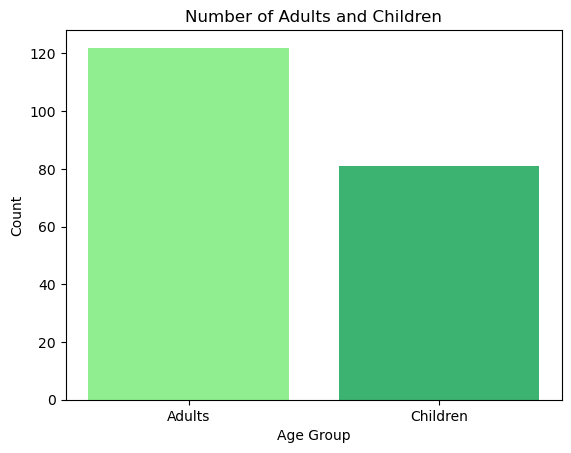

In [9]:
# Count the occurrences of each age group
age_counts = df["Age Group"].value_counts()

# Plot bar graph
plt.bar(age_counts.index, age_counts.values, color=["lightgreen", "mediumseagreen"])
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.title("Number of Adults and Children")
plt.show()

We will create a simple bar graph to assess the number of children and adults in the dataset.

We will further categorise the data into active and passive groups and assess the number of children and adults in the data.

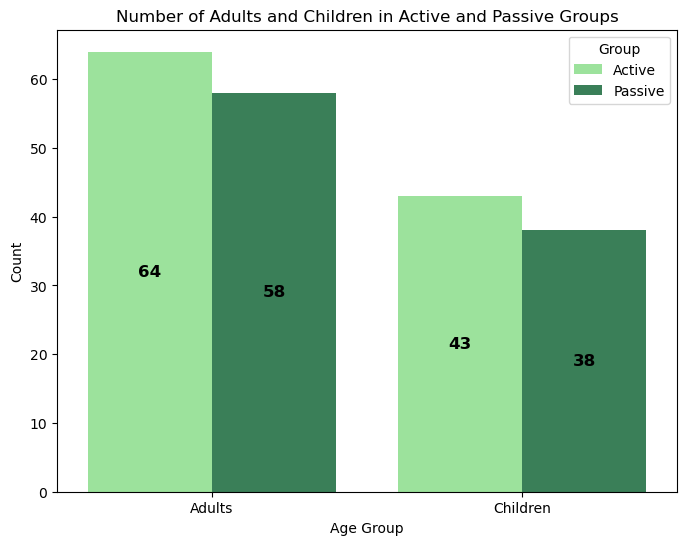

In [10]:
# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="Age Group", hue="Active/Passive", data=df, palette=["lightgreen", "seagreen"])

# Add labels inside bars
for p in ax.patches:
    height = p.get_height()  # Get bar height
    if height > 0:  # Avoid adding labels to empty bars
        ax.text(
            p.get_x() + p.get_width() / 2,  # X position (center of bar)
            height / 2,  # Y position (middle of bar)
            int(height),  # Convert count to integer
            ha="center", va="center", fontsize=12, fontweight="bold", color="black"
        )

# Add labels and title
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.title("Number of Adults and Children in Active and Passive Groups")
plt.legend(title="Group", loc="upper right")  # Adjust legend position if needed

# Show plot
plt.show()

### Extract Average Severity Levels for each session

We will now extract the severity levels from the data. If it is 1, the case is Mild. If it is 2, the case is Moderate, and if it is 3, the case is Severe.

In [11]:
# Ensure 'Active/Passive' column is treated as categorical
df["Active/Passive"] = df["Active/Passive"].astype(str)

# Extract all session-related columns
session_columns = [col for col in df.columns if col.startswith("Session ")]

# Extract session numbers dynamically (Fix: Added extra parentheses inside set)
session_numbers = sorted(set(int(re.search(r"(\d+)", col).group()) for col in session_columns if re.search(r"(\d+)", col)))

# Initialize lists to store average values for each group
session_averages_active = []
session_averages_passive = []

# Compute the average problem intensity for each session, grouped by Active/Passive
for session in session_numbers:
    session_cols = [col for col in session_columns if f"Session {session} " in col]  # Match all columns for the session
    
    # Compute the average across session-related columns
    df[f"Session {session} Avg"] = df[session_cols].mean(axis=1)

    # Store averages for each group (Fix: Used correct logical indexing)
    session_averages_active.append(df.loc[(df["Active/Passive"] == "Active") & (session <= 35), f"Session {session} Avg"].mean())
    session_averages_passive.append(df.loc[(df["Active/Passive"] == "Passive") & (session <= 30), f"Session {session} Avg"].mean())


## Visualization 

We will now use the weighted subluxation scores to visualise the data. 

### Line Plot for Weighted subscores

The line plot for overall weighted subluxation scores shows a downward trend for both active and passive groups. Scores for the passive groups start of as higher than the Active scores initially, and decline drastically especially between Session 17 and 19.

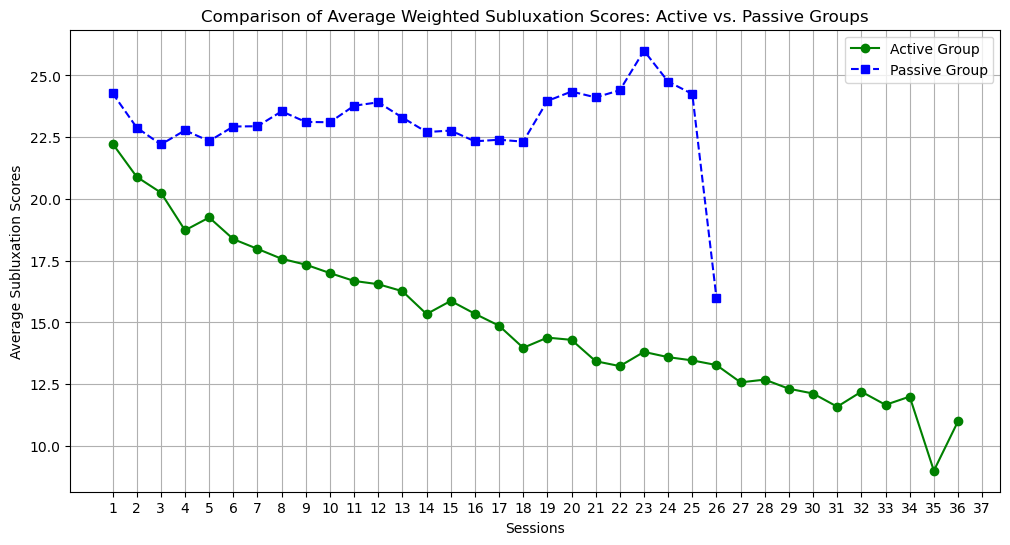

In [12]:
# Extract session weighted sum columns
weight_cols = [col for col in df_weight.columns if "Weighted Sum" in col]

# Initialize lists to store average weighted sums
weighted_active_avg = []
weighted_passive_avg = []

# Loop over session columns to calculate averages (excluding zeros)
for session in weight_cols:
    active_vals = df_weight.loc[(df_weight["Active/Passive"] == "Active") & (df_weight[session] != 0), session]
    passive_vals = df_weight.loc[(df_weight["Active/Passive"] == "Passive") & (df_weight[session] != 0), session]

    weighted_active_avg.append(active_vals.mean())
    weighted_passive_avg.append(passive_vals.mean())

# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(weight_cols, weighted_active_avg, marker='o', linestyle='-', label="Active Group", color='green')
plt.plot(weight_cols, weighted_passive_avg, marker='s', linestyle='--', label="Passive Group", color='blue')

# Improve readability
plt.xlabel("Sessions")
plt.ylabel("Average Subluxation Scores")
plt.title("Comparison of Average Weighted Subluxation Scores: Active vs. Passive Groups")
plt.xticks(ticks=range(37), labels=range(1, 38))  # Sessions as 1 to 37
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Weighted Subscores for Adults and Children

We will categorise the data into Adults and Chidlren. The line plots show similar results, with downward trends in both the graphs. However, for Passive Children, the decline is less gradual than it is for the Active Group, perhaps due to a decline in the number of visits to the clinic.

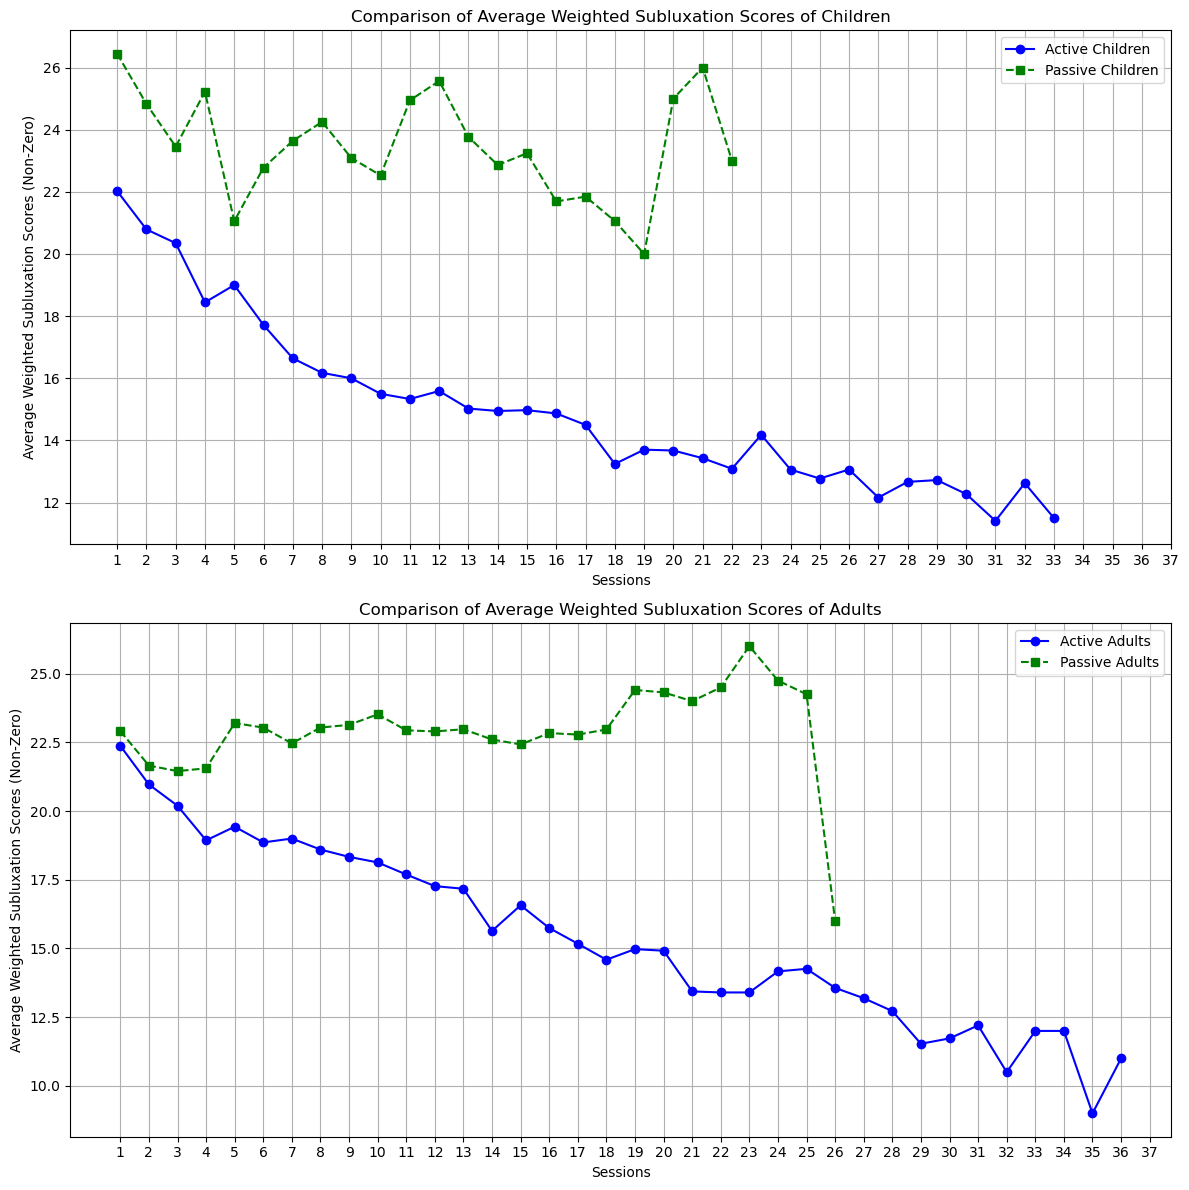

In [46]:
# Extract session weighted sum columns
weight_cols = [col for col in df_weight.columns if "Weighted Sum" in col]

# Initialize lists to store average weighted sums
weighted_active_children_avg = []
weighted_active_adults_avg = []
weighted_passive_children_avg = []
weighted_passive_adults_avg = []

# Loop over session columns to calculate averages (non-zero values only), grouped by Age Group and Active/Passive
for session in weight_cols:
    # Active Children
    weighted_active_children_avg.append(df_weight.loc[
        (df_weight["Active/Passive"] == "Active") &
        (df_weight["Age Group"] == "Children") &
        (df_weight[session] != 0),
        session
    ].mean())

    # Active Adults
    weighted_active_adults_avg.append(df_weight.loc[
        (df_weight["Active/Passive"] == "Active") &
        (df_weight["Age Group"] == "Adults") &
        (df_weight[session] != 0),
        session
    ].mean())

    # Passive Children
    weighted_passive_children_avg.append(df_weight.loc[
        (df_weight["Active/Passive"] == "Passive") &
        (df_weight["Age Group"] == "Children") &
        (df_weight[session] != 0),
        session
    ].mean())

    # Passive Adults
    weighted_passive_adults_avg.append(df_weight.loc[
        (df_weight["Active/Passive"] == "Passive") &
        (df_weight["Age Group"] == "Adults") &
        (df_weight[session] != 0),
        session
    ].mean())

# Create two separate subplots for Children and Adults groups
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot Children group in the first subplot
axes[0].plot(weight_cols, weighted_active_children_avg, marker='o', linestyle='-', label="Active Children", color='blue')
axes[0].plot(weight_cols, weighted_passive_children_avg, marker='s', linestyle='--', label="Passive Children", color='green')
axes[0].set_xlabel("Sessions")
axes[0].set_ylabel("Average Weighted Subluxation Scores (Non-Zero)")
axes[0].set_title("Comparison of Average Weighted Subluxation Scores of Children")
axes[0].set_xticks(range(37))
axes[0].set_xticklabels(range(1, 38))  # Sessions as 1 to 37
axes[0].legend()
axes[0].grid(True)

# Plot Adults group in the second subplot
axes[1].plot(weight_cols, weighted_active_adults_avg, marker='o', linestyle='-', label="Active Adults", color='blue')
axes[1].plot(weight_cols, weighted_passive_adults_avg, marker='s', linestyle='--', label="Passive Adults", color='green')
axes[1].set_xlabel("Sessions")
axes[1].set_ylabel("Average Weighted Subluxation Scores (Non-Zero)")
axes[1].set_title("Comparison of Average Weighted Subluxation Scores of Adults")
axes[1].set_xticks(range(37))
axes[1].set_xticklabels(range(1, 38))  # Sessions as 1 to 37
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()

### Heatmap for Weighted subscores

The heatmap shows similar results. It indicates that while the subluxation scores for adults gradually decline, this decline in children is more apparent.

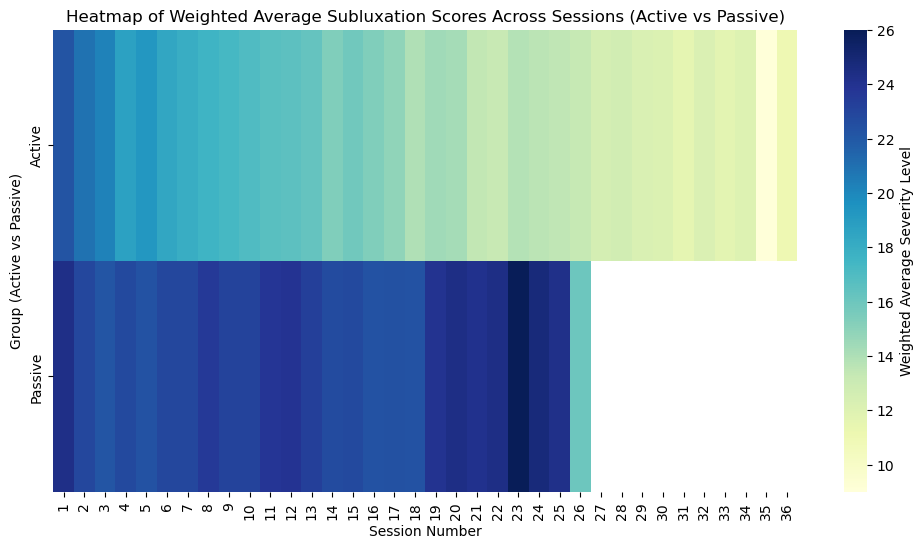

In [47]:
# Create a DataFrame for the heatmap
heatmap_data = pd.DataFrame({
    'Active': weighted_active_avg,
    'Passive': weighted_passive_avg
}, index=session_numbers)

# Plot the heatmap 
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data.T, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Weighted Average Severity Level'})
plt.title("Heatmap of Weighted Average Subluxation Scores Across Sessions (Active vs Passive)")
plt.xlabel("Session Number")
plt.ylabel("Group (Active vs Passive)")
plt.xticks(rotation=90)
plt.show()

### Number of Mild, Moderate, and Severe Subluxation cases per Session

We will now assess the number of Mild, Moderate, and Severe Subluxation cases across the sessions. We notice that the number of severe cases for the Active group fall, which may be a good indication. However, the Moderate and Mild cases initially increase, and then gradually fall. Similar patterns are observed in the Passive Group.

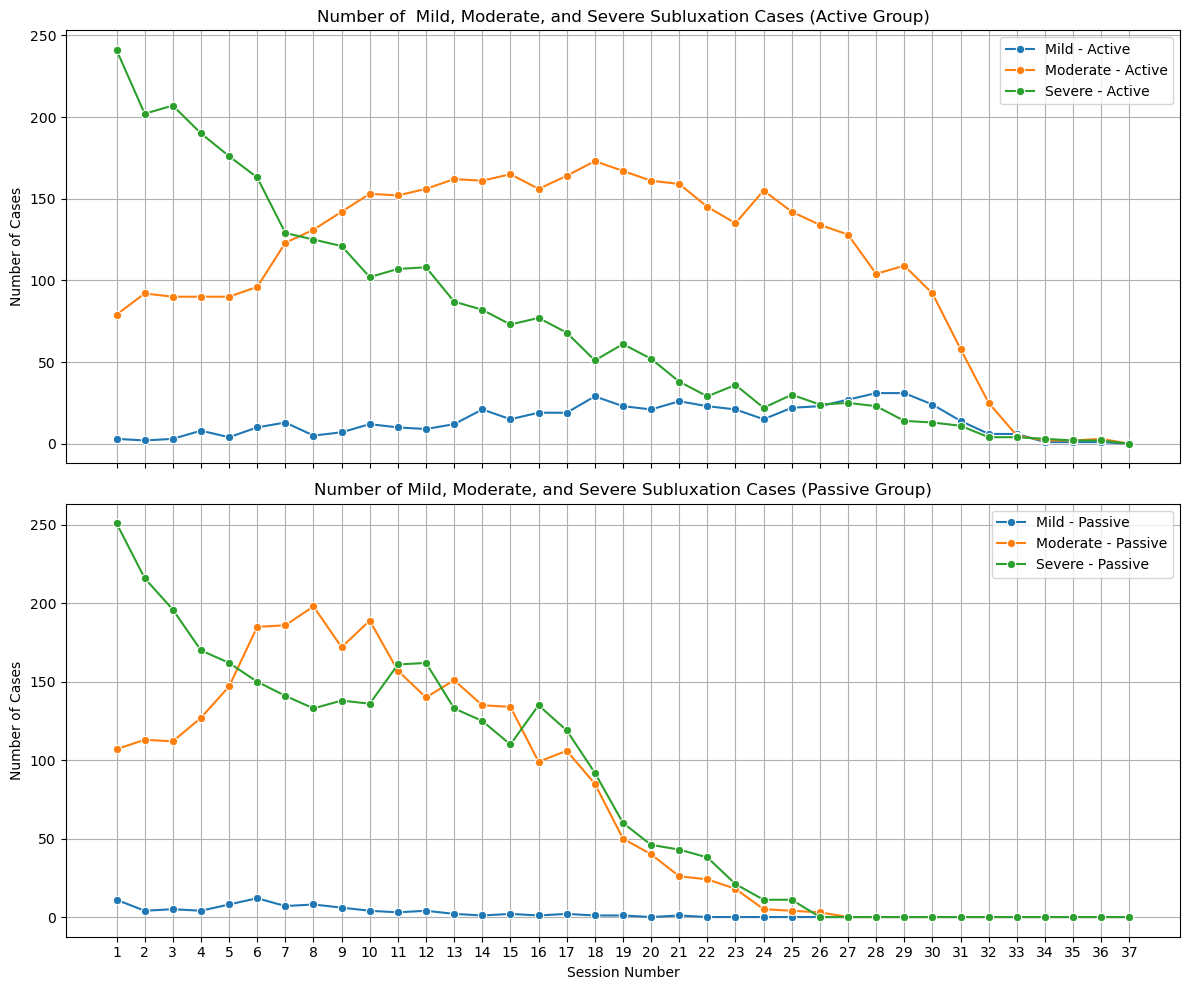

In [48]:
# Ensure 'Active/Passive' column is treated as categorical
df["Active/Passive"] = df["Active/Passive"].astype(str)

# Extract all session-related columns
session_columns = [col for col in df.columns if col.startswith("Session ")]

# Extract session numbers dynamically
session_numbers = list(range(1, 38))  # Ensure x-axis runs from 1 to 37

# Function to compute counts for a given group (Active or Passive)
def compute_counts(df, group):
    counts_df = pd.DataFrame(index=[1, 2, 3])  # Only include values 1, 2, and 3
    for session in session_numbers:
        session_cols = [col for col in session_columns if f"Session {session} " in col]  
        if session_cols:  # Only process if columns exist
            session_data = df.loc[df["Active/Passive"] == group, session_cols].fillna(-1).astype(int).values.ravel()
            count_series = pd.Series(session_data[session_data >= 0]).value_counts().sort_index()
            count_series = count_series.reindex([1, 2, 3], fill_value=0)  # Ensure only 1, 2, and 3 are included
        else:
            count_series = pd.Series([0, 0, 0], index=[1, 2, 3])  # Fill missing sessions with 0s
        counts_df[f"Session {session}"] = count_series
    return counts_df.T  # Transpose for proper plotting

# Compute counts for both groups
counts_df_active = compute_counts(df, "Active")
counts_df_passive = compute_counts(df, "Passive")

# Define severity labels
severity_labels = {1: "Mild", 2: "Moderate", 3: "Severe"}

# Create figure and subplots (stacked vertically)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot for Active group
for value in [1, 2, 3]:
    sns.lineplot(ax=axes[0], x=session_numbers, y=counts_df_active.get(value, [0]*len(session_numbers)), 
                 marker='o', label=f"{severity_labels[value]} - Active")

axes[0].set_title("Number of  Mild, Moderate, and Severe Subluxation Cases (Active Group)")
axes[0].set_ylabel("Number of Cases")
axes[0].legend()
axes[0].grid(True)

# Plot for Passive group
for value in [1, 2, 3]:
    sns.lineplot(ax=axes[1], x=session_numbers, y=counts_df_passive.get(value, [0]*len(session_numbers)), 
                 marker='o', label=f"{severity_labels[value]} - Passive")

axes[1].set_title("Number of Mild, Moderate, and Severe Subluxation Cases (Passive Group)")
axes[1].set_xlabel("Session Number")
axes[1].set_ylabel("Number of Cases")
axes[1].legend()
axes[1].grid(True)

# Set x-axis ticks to be 1 to 37
axes[1].set_xticks(session_numbers)

# Adjust layout and show plots
plt.tight_layout()
plt.show()

### Number of Mild, Moderate and Severe Cases in Children

We will now assess the number of Mild, Moderate, and Severe Subluxation cases across the sessions for children. We notice that the number of severe cases for the Active group fall, which may be a good indication. However, the Moderate and Mild cases initially increase, and then gradually fall. Similar patterns are observed in the Passive Group.

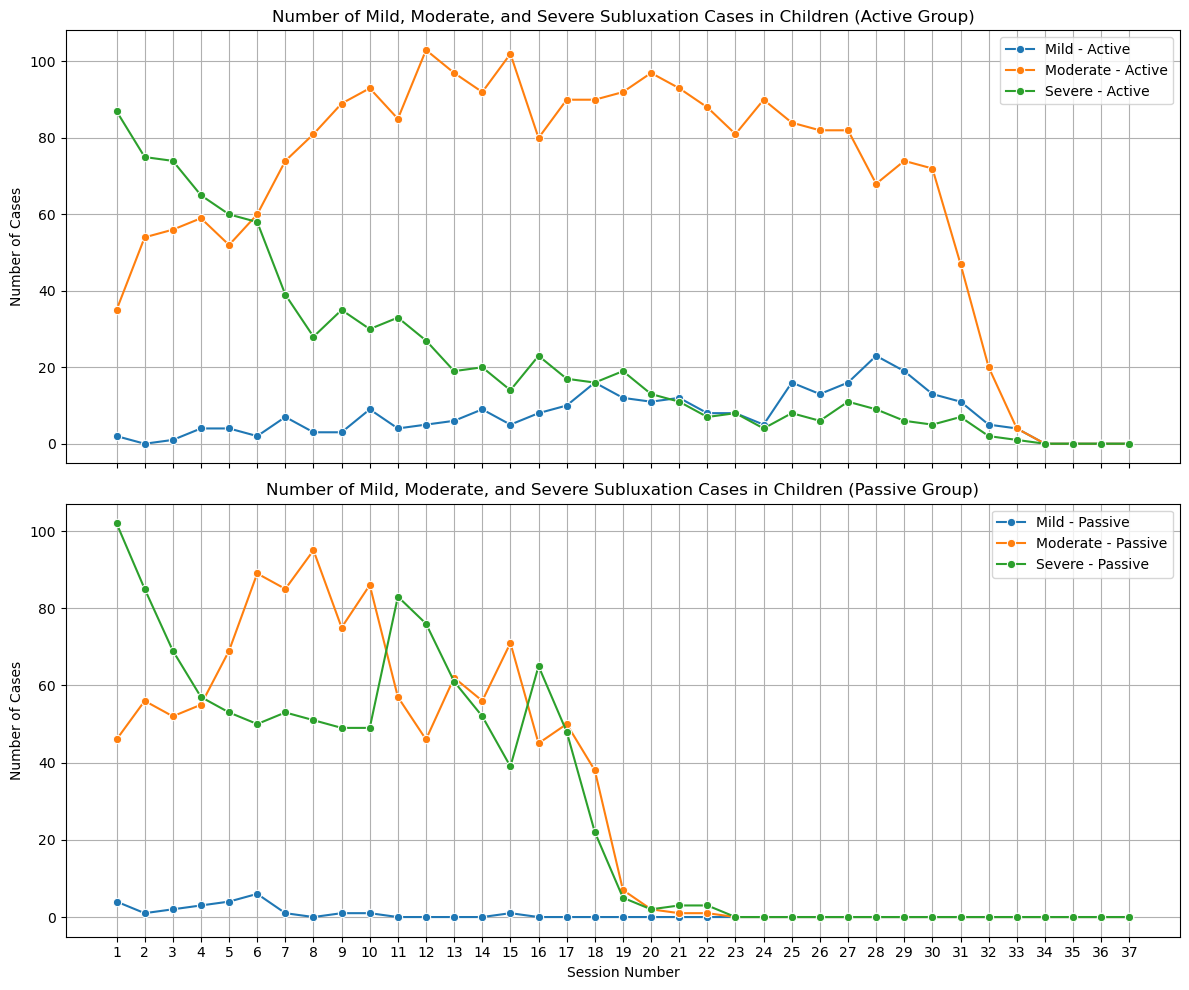

In [49]:
# Ensure 'Active/Passive' column is treated as categorical
df["Active/Passive"] = df["Active/Passive"].astype(str)

# Filter the data for 'Children' only
df_children = df[df["Age Group"] == "Children"]

# Extract all session-related columns
session_columns = [col for col in df.columns if col.startswith("Session ")]

# Extract session numbers dynamically
session_numbers = list(range(1, 38))  # Ensure x-axis runs from 1 to 37

# Function to compute counts for a given group (Active or Passive)
def compute_counts(df, group):
    counts_df = pd.DataFrame(index=[1, 2, 3])  # Only include values 1, 2, and 3
    for session in session_numbers:
        session_cols = [col for col in session_columns if f"Session {session} " in col]  
        if session_cols:  # Only process if columns exist
            session_data = df.loc[df["Active/Passive"] == group, session_cols].fillna(-1).astype(int).values.ravel()
            count_series = pd.Series(session_data[session_data >= 0]).value_counts().sort_index()
            count_series = count_series.reindex([1, 2, 3], fill_value=0)  # Ensure only 1, 2, and 3 are included
        else:
            count_series = pd.Series([0, 0, 0], index=[1, 2, 3])  # Fill missing sessions with 0s
        counts_df[f"Session {session}"] = count_series
    return counts_df.T  # Transpose for proper plotting

# Compute counts for both Active and Passive groups for Children
counts_df_active_children = compute_counts(df_children, "Active")
counts_df_passive_children = compute_counts(df_children, "Passive")

# Define severity labels
severity_labels = {1: "Mild", 2: "Moderate", 3: "Severe"}

# Create figure and subplots (stacked vertically)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot for Active Children group
for value in [1, 2, 3]:
    sns.lineplot(ax=axes[0], x=session_numbers, y=counts_df_active_children.get(value, [0]*len(session_numbers)), 
                 marker='o', label=f"{severity_labels[value]} - Active")

axes[0].set_title("Number of Mild, Moderate, and Severe Subluxation Cases in Children (Active Group)")
axes[0].set_ylabel("Number of Cases")
axes[0].legend()
axes[0].grid(True)

# Plot for Passive Children group
for value in [1, 2, 3]:
    sns.lineplot(ax=axes[1], x=session_numbers, y=counts_df_passive_children.get(value, [0]*len(session_numbers)), 
                 marker='o', label=f"{severity_labels[value]} - Passive")

axes[1].set_title("Number of Mild, Moderate, and Severe Subluxation Cases in Children (Passive Group)")
axes[1].set_xlabel("Session Number")
axes[1].set_ylabel("Number of Cases")
axes[1].legend()
axes[1].grid(True)

# Set x-axis ticks to be 1 to 37
axes[1].set_xticks(session_numbers)

# Adjust layout and show plots
plt.tight_layout()
plt.show()


### Number of Mild, Moderate and Severe Cases in Adults

We will now assess the number of Mild, Moderate, and Severe Subluxation cases across the sessions for adults. We notice that the number of severe cases for the Active group fall, which may be a good indication. However, the Moderate and Mild cases initially increase, and then gradually fall. Similar patterns are observed in the Passive Group.

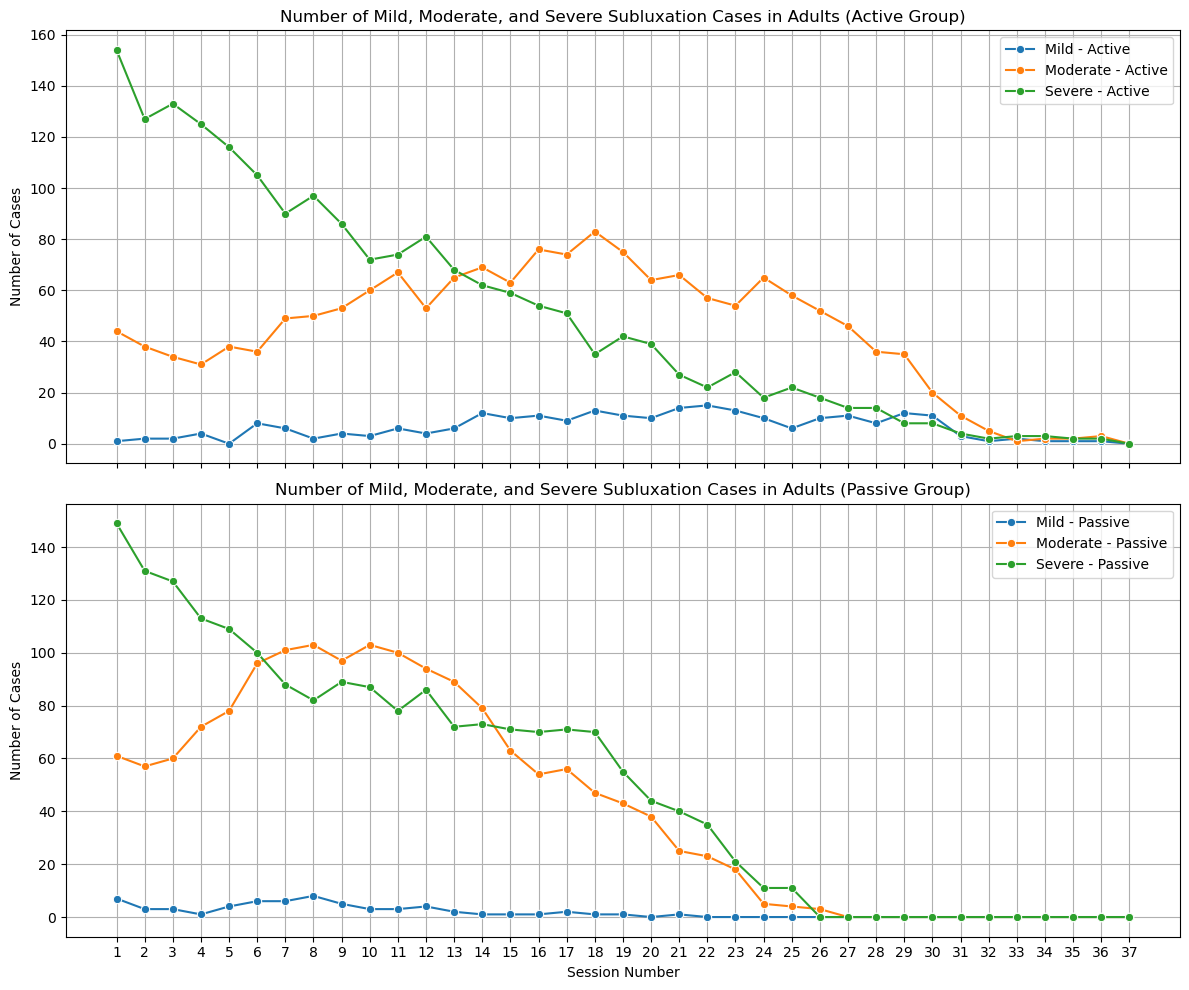

In [50]:
# Ensure 'Active/Passive' column is treated as categorical
df["Active/Passive"] = df["Active/Passive"].astype(str)

# Filter the data for 'Children' only
df_adults = df[df["Age Group"] == "Adults"]

# Extract all session-related columns
session_columns = [col for col in df.columns if col.startswith("Session ")]

# Extract session numbers dynamically
session_numbers = list(range(1, 38))  # Ensure x-axis runs from 1 to 37

# Function to compute counts for a given group (Active or Passive)
def compute_counts(df, group):
    counts_df = pd.DataFrame(index=[1, 2, 3])  # Only include values 1, 2, and 3
    for session in session_numbers:
        session_cols = [col for col in session_columns if f"Session {session} " in col]  
        if session_cols:  # Only process if columns exist
            session_data = df.loc[df["Active/Passive"] == group, session_cols].fillna(-1).astype(int).values.ravel()
            count_series = pd.Series(session_data[session_data >= 0]).value_counts().sort_index()
            count_series = count_series.reindex([1, 2, 3], fill_value=0)  # Ensure only 1, 2, and 3 are included
        else:
            count_series = pd.Series([0, 0, 0], index=[1, 2, 3])  # Fill missing sessions with 0s
        counts_df[f"Session {session}"] = count_series
    return counts_df.T  # Transpose for proper plotting

# Compute counts for both Active and Passive groups for Adults
counts_df_active_adults = compute_counts(df_adults, "Active")
counts_df_passive_adults = compute_counts(df_adults, "Passive")

# Define severity labels
severity_labels = {1: "Mild", 2: "Moderate", 3: "Severe"}

# Create figure and subplots (stacked vertically)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot for Active Adults group
for value in [1, 2, 3]:
    sns.lineplot(ax=axes[0], x=session_numbers, y=counts_df_active_adults.get(value, [0]*len(session_numbers)), 
                 marker='o', label=f"{severity_labels[value]} - Active")

axes[0].set_title("Number of Mild, Moderate, and Severe Subluxation Cases in Adults (Active Group)")
axes[0].set_ylabel("Number of Cases")
axes[0].legend()
axes[0].grid(True)

# Plot for Passive Children group
for value in [1, 2, 3]:
    sns.lineplot(ax=axes[1], x=session_numbers, y=counts_df_passive_adults.get(value, [0]*len(session_numbers)), 
                 marker='o', label=f"{severity_labels[value]} - Passive")

axes[1].set_title("Number of Mild, Moderate, and Severe Subluxation Cases in Adults (Passive Group)")
axes[1].set_xlabel("Session Number")
axes[1].set_ylabel("Number of Cases")
axes[1].legend()
axes[1].grid(True)

# Set x-axis ticks to be 1 to 37
axes[1].set_xticks(session_numbers)

# Adjust layout and show plots
plt.tight_layout()
plt.show()


### Number of Visits Per Session

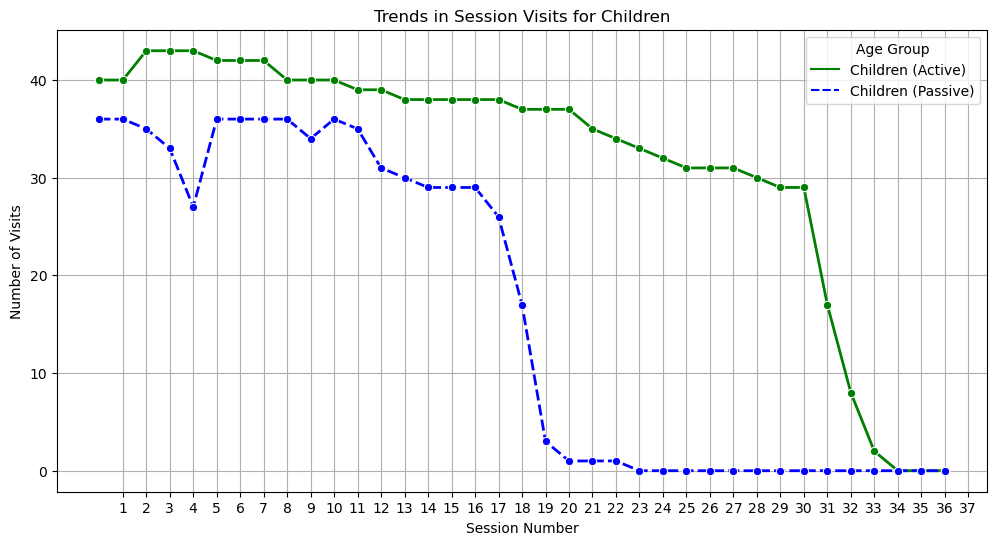

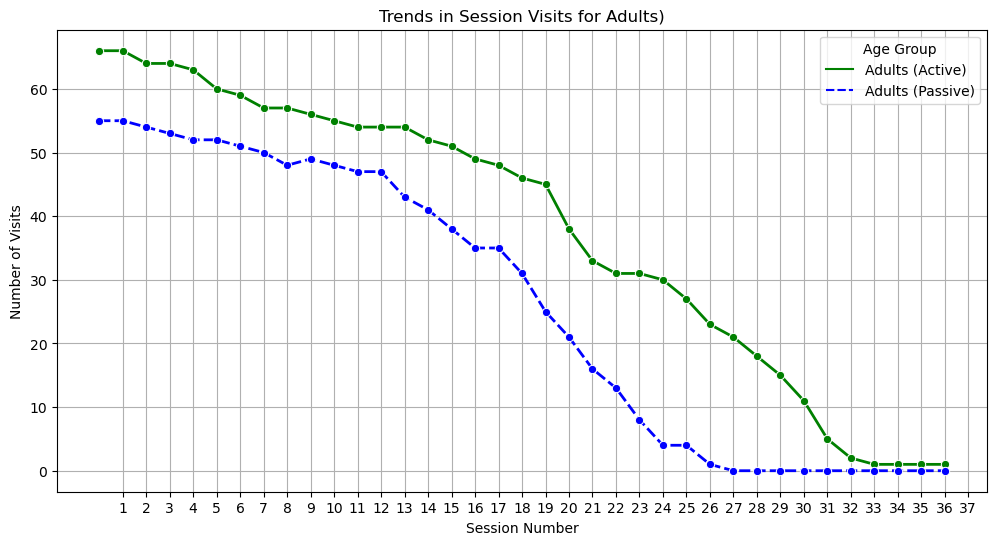

In [51]:
# Filter only Children
df_children_counts = df_sessions[df_sessions["Age Group"].isin(["Children (Active)", "Children (Passive)"])]

# Set "Age Group" as index and transpose so sessions are on the x-axis
df_children_counts = df_children_counts.set_index("Age Group").T  

# Plot for Active group
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_children_counts, marker="o", linewidth=2, palette = ("green", "blue"))

# Formatting
plt.xlabel("Session Number")
plt.ylabel("Number of Visits")
plt.title("Trends in Session Visits for Children")
plt.xticks(ticks=range(1, 38), labels=range(1, 38))  # Ensure x-axis runs from 1 to 37
plt.legend(title="Age Group")
plt.grid(True)

# Show plot
plt.show()

# Filter only Passive groups
df_adult_counts = df_sessions[df_sessions["Age Group"].isin(["Adults (Active)", "Adults (Passive)"])]

# Set "Age Group" as index and transpose so sessions are on the x-axis
df_adult_counts = df_adult_counts.set_index("Age Group").T  

# Plot for Adults 
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_adult_counts, marker="o", linewidth=2, palette = ("green", "blue"))

# Formatting
plt.xlabel("Session Number")
plt.ylabel("Number of Visits")
plt.title("Trends in Session Visits for Adults)")
plt.xticks(ticks=range(1, 38), labels=range(1, 38))  # Ensure x-axis runs from 1 to 37
plt.legend(title="Age Group")
plt.grid(True)

# Show plot
plt.show()

### Box Plots for Active Group Visits

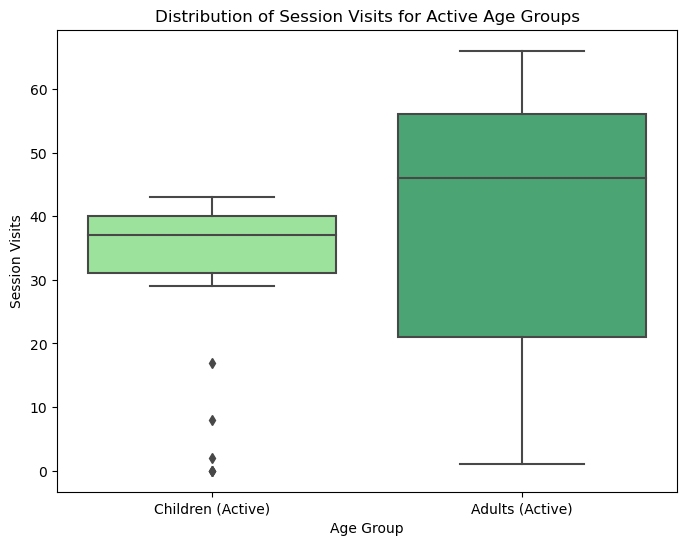

In [52]:
# Identify session visit columns
visit_cols = [col for col in df_sessions.columns if "Visits" in col]

# Convert to long format with all visits in one category
df_melted = df_sessions.melt(id_vars=["Age Group"], value_vars=visit_cols, var_name="Session", value_name="Visits")

# Filter data for Children (Active) and Adults (Active)
df_filtered = df_melted[df_melted["Age Group"].isin(["Children (Active)", "Adults (Active)"])]

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="Age Group", y="Visits", data=df_filtered, palette = ("lightgreen", "mediumseagreen"))

# Add title and labels
plt.title("Distribution of Session Visits for Active Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Session Visits")

# Show the plot
plt.show()

### Box Plots for Passive Group Visits

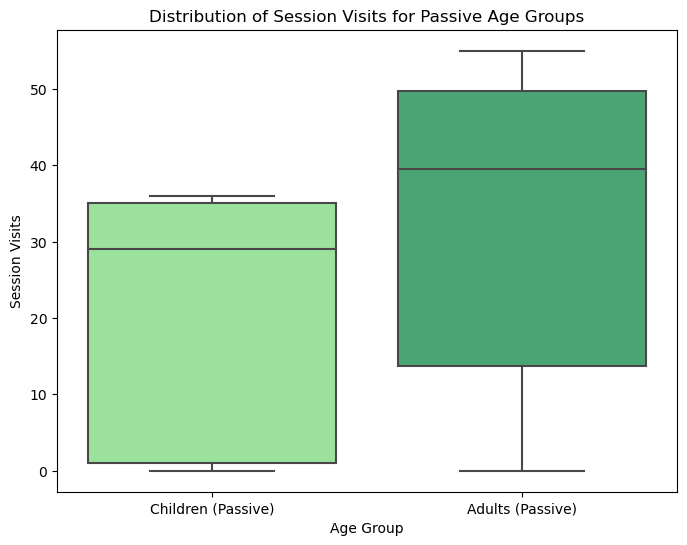

In [53]:
# Identify session visit columns (first 30 only)
visit_cols = [col for col in df_sessions.columns if "Visits" in col][:30]

# Convert to long format with all visits in one category
df_melted = df_sessions.melt(id_vars=["Age Group"], value_vars=visit_cols, var_name="Session", value_name="Visits")

# Filter data for Children (Passive) and Adults (Passive)
df_filtered = df_melted[df_melted["Age Group"].isin(["Children (Passive)", "Adults (Passive)"])]

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x="Age Group", y="Visits", data=df_filtered, palette = ("lightgreen", "mediumseagreen"))

# Add title and labels
plt.title("Distribution of Session Visits for Passive Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Session Visits")

# Show the plot
plt.show()

# Without Weights


# Exploratory Analysis of Stress Data

### Creating separate dataframes for children and adult data

In [54]:
children = df_weight[df_weight["Age Group"] == "Children"]
adults = df_weight[df_weight["Age Group"] == "Adults"]

Combining df_hairsaliva with children and adult data. ADULTS ONLY HAVE 4 OBSERATIONS SO THE DATA CAN BE OMITTED?

In [55]:
df_children = children.merge(df_hairsaliva, on="ID", how="inner")  

Combining df_bloodsaliva with adults data.


In [56]:
df_adult= adults.merge(df_bloodsaliva, on = "ID", how = "outer")

In [57]:
#df_diff = children.merge(df_hairsaliva, on="ID", how="outer", indicator=True)
#missing_row = df_diff[df_diff["_merge"] != "both"]  # Rows present in only one of the DataFrames

Combining DASS scores data with adults data.

In [58]:
df_adults = df_adult.merge(df_dass, on = "ID", how = "outer")

Saving datasets

In [59]:
df_children.to_csv("data_children.csv", index=False)
#df_adults.to_csv("data_adults.csv", index=False)

### Visualization

### Children

#### Hair Cortisol

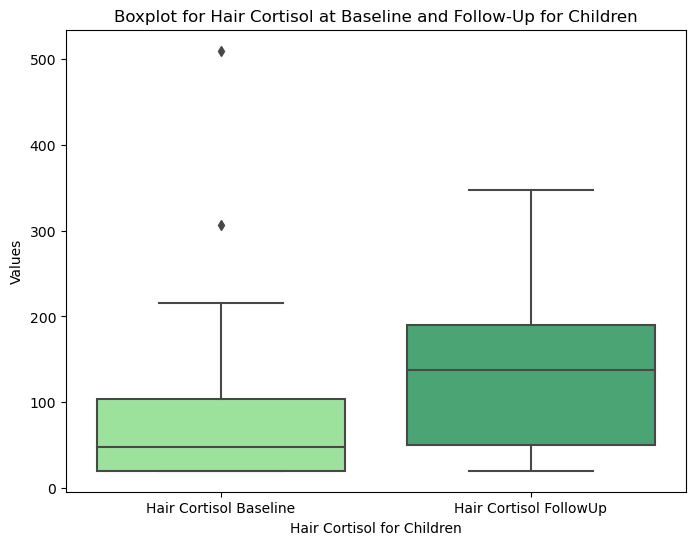

In [60]:
columns_to_plot = ["Hair Cortisol Baseline", "Hair Cortisol FollowUp"]

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_children[columns_to_plot], palette=("lightgreen", "mediumseagreen"))

# Add labels and title
plt.xlabel("Hair Cortisol for Children")
plt.ylabel("Values")
plt.title("Boxplot for Hair Cortisol at Baseline and Follow-Up for Children")
plt.show()

#### Saliva Cortisol

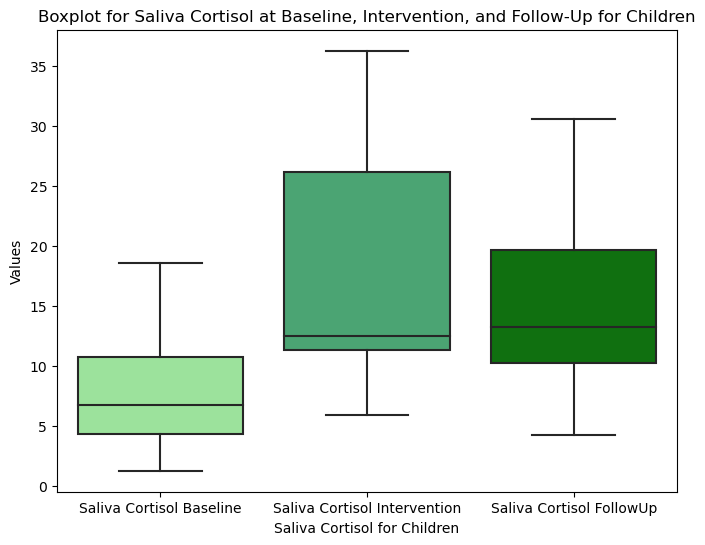

In [61]:
columns_to_plot = ["Saliva Cortisol Baseline", "Saliva Cortisol Intervention", "Saliva Cortisol FollowUp"]

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_children[columns_to_plot], palette=("lightgreen", "mediumseagreen", "green"))

# Add labels and title
plt.xlabel("Saliva Cortisol for Children")
plt.ylabel("Values")
plt.title("Boxplot for Saliva Cortisol at Baseline, Intervention, and Follow-Up for Children")
plt.show()

### Adults

#### Blood Cortisol

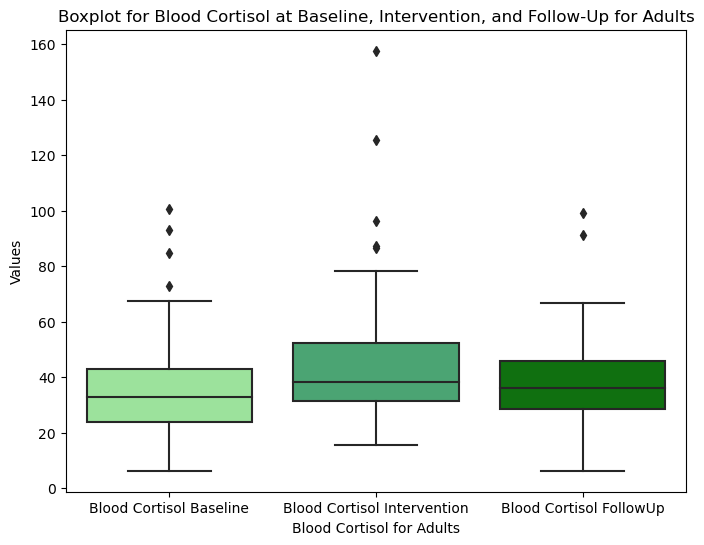

In [62]:
columns_to_plot = ["Blood Cortisol Baseline", "Blood Cortisol Intervention", "Blood Cortisol FollowUp"]

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_adults[columns_to_plot], palette=("lightgreen", "mediumseagreen", "green"))

# Add labels and title
plt.xlabel("Blood Cortisol for Adults")
plt.ylabel("Values")
plt.title("Boxplot for Blood Cortisol at Baseline, Intervention, and Follow-Up for Adults")
plt.show()

#### Saliva Cortisol

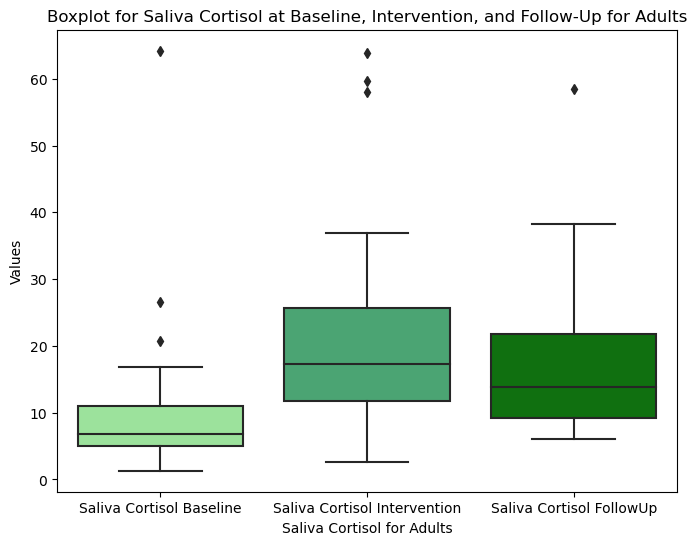

In [63]:
columns_to_plot = ["Saliva Cortisol Baseline", "Saliva Cortisol Intervention", "Saliva Cortisol FollowUp"]

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_adults[columns_to_plot], palette=("lightgreen", "mediumseagreen", "green"))

# Add labels and title
plt.xlabel("Saliva Cortisol for Adults")
plt.ylabel("Values")
plt.title("Boxplot for Saliva Cortisol at Baseline, Intervention, and Follow-Up for Adults")
plt.show()

#### DASS Scores

In [64]:

# Example data
df = df_subcat

# Correct the typo
df = df.rename(columns={'Aniety': 'Anxiety'})

# Split ID and Category
df['ID'] = df['Name2'].str.extract(r'(\d+)')
df['Category'] = df['Name2'].str.extract(r'([A-Z])')

# Melt to long format
df_melted = df.melt(id_vars=['ID', 'Category'], value_vars=['Depression', 'Anxiety', 'Stress'],
                    var_name='Measure', value_name='Value')

# Map categories to time points
category_mapping = {
    'A': 'Baseline',
    'B': 'Week 6',
    'C': 'Week 12',
    'D': 'Week 16'
}
df_melted['TimePoint'] = df_melted['Category'].map(category_mapping)

# Create new combined column names
df_melted['NewCol'] = df_melted['Measure'] + '_' + df_melted['TimePoint']

# Pivot
final_df = df_melted.pivot_table(index='ID', columns='NewCol', values='Value')

# Reset index
final_df = final_df.reset_index()

# Sort by ID
final_df['ID'] = final_df['ID'].astype(int)
final_df = final_df.sort_values('ID')

final_df

NewCol,ID,Anxiety_Baseline,Anxiety_Week 12,Anxiety_Week 16,Anxiety_Week 6,Depression_Baseline,Depression_Week 12,Depression_Week 16,Depression_Week 6,Stress_Baseline,Stress_Week 12,Stress_Week 16,Stress_Week 6
0,1,10.5,9.5,5.0,11.0,8.5,8.5,5.0,9.0,11.0,6.0,7.0,13.0
42,2,10.0,0.0,3.0,7.0,7.0,0.0,0.0,5.0,8.0,1.0,1.0,9.0
67,3,2.0,3.0,3.0,4.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0
74,4,3.0,NaN,NaN,0.0,1.0,NaN,NaN,0.0,2.0,NaN,NaN,0.0
78,5,5.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0,9.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,218,5.0,NaN,NaN,5.0,3.0,NaN,NaN,9.0,4.0,NaN,NaN,9.0
58,220,0.5,0.0,NaN,NaN,2.0,0.0,NaN,NaN,3.5,0.0,NaN,NaN
59,221,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,222,0.0,NaN,NaN,0.0,2.0,NaN,NaN,2.0,9.0,NaN,NaN,6.0


In [65]:
# Merge on 'ID'
df_adults = pd.merge(df_adults, final_df, on='ID', how='left')

In [66]:
df_adults.to_csv("data_adults.csv", index=False)
df_adults

,Unnamed: 0,ID,Enrolment Date,Initial Care Plan,Age Group,Active/Passive,Session 1,Session 1 Weighted Sum,Session 1 Cervical,Session 1 Lumbar,...,Anxiety_Week 16,Anxiety_Week 6,Depression_Baseline,Depression_Week 12,Depression_Week 16,Depression_Week 6,Stress_Baseline,Stress_Week 12,Stress_Week 16,Stress_Week 6
0,0.0,1,20/4,3x4,Adults,Active,2022-04-20 14:00:00,26.0,15.0,2.0,...,5.0,11.0,8.5,8.5,5.0,9.0,11.0,6.0,7.0,13.0
1,1.0,2,20/4,3x4,Adults,Active,2022-04-20 12:35:00,19.0,8.0,3.0,...,3.0,7.0,7.0,0.0,0.0,5.0,8.0,1.0,1.0,9.0
2,2.0,4,19/4,3x4,Adults,Active,2022-04-19 12:55:00,17.0,9.0,0.0,...,NaN,0.0,1.0,NaN,NaN,0.0,2.0,NaN,NaN,0.0
3,3.0,5,21/4,3x4,Adults,Active,2022-04-21 12:35:00,25.0,13.0,5.0,...,0.0,0.0,0.0,5.0,0.0,0.0,2.0,9.0,0.0,0.0
4,4.0,6,20/4,3x4,Adults,Active,2022-04-20 13:40:00,24.0,15.0,2.0,...,5.0,9.0,7.0,10.0,4.0,4.0,11.0,9.0,4.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,192.0,217,NaN,2x6,Adults,Passive,2022-06-02 10:35:00,23.0,13.0,0.0,...,1.0,3.0,3.0,0.0,1.0,0.0,5.0,0.0,1.0,1.0
119,193.0,220,NaN,2x6,Adults,Passive,2022-06-02 10:28:00,24.0,13.0,0.0,...,NaN,NaN,2.0,0.0,NaN,NaN,3.5,0.0,NaN,NaN
120,194.0,221,2022-09-06 00:00:00,NaN,Adults,Passive,NaT,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,195.0,223,2022-09-06 00:00:00,NaN,Adults,Passive,2022-06-09 08:44:00,22.0,15.0,0.0,...,0.0,0.0,0.0,NaN,1.0,0.0,0.0,NaN,2.0,1.0


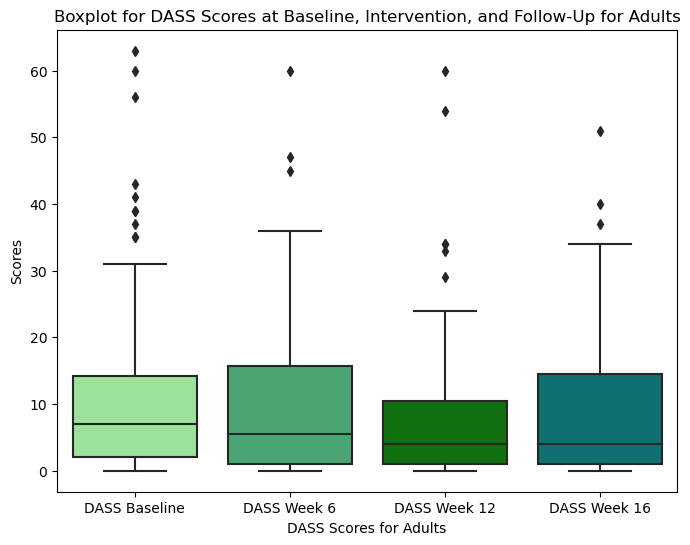

In [67]:
columns_to_plot = ["DASS Baseline", "DASS Week 6", "DASS Week 12", "DASS Week 16"]

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_adults[columns_to_plot], palette=("lightgreen", "mediumseagreen", "green", "teal"))

# Add labels and title
plt.xlabel("DASS Scores for Adults")
plt.ylabel("Scores")
plt.title("Boxplot for DASS Scores at Baseline, Intervention, and Follow-Up for Adults")
plt.show()